In [ ]:
from bs4 import BeautifulSoup
import requests
import re

In [ ]:
url ='https://www.airlinequality.com/airline-reviews/british-airways'
page= requests.get(url)
soup= BeautifulSoup(page.content,"html.parser")

In [ ]:
rating, header,author, date, place, verification, content, collect=[],[],[],[],[],[],[],[]
urls=[url]
c=1
while(soup!=None):
    articles = soup.find_all("article", attrs={'class':re.compile('comp comp_media-review-rated list-item media position-content review-[0-9]*')})
    for article in articles:
        if(article.find("div",class_='rating-10').find('span') is None):
            rating.append(None)
        else:
            rating.append(article.find("div",class_='rating-10').find('span').text)
        if(article.find("div",class_='body').find('h2') is None):
            header.append(None)
        else:
            header.append(article.find("div",class_='body').find('h2').text.strip("\""))
        if(article.find("div",class_='body').find('span',itemprop='author').find('span') is None):
            author.append(None)
        else:
            author.append(article.find("div",class_='body').find('span',itemprop='author').find('span').text)
        if(article.find("div",class_='body').find('time',itemprop='datePublished') is None):
            date.append(None)
        else:
            date.append(article.find("div",class_='body').find('time',itemprop='datePublished')['datetime'])
        if(re.search(r".*(\(.*\)).*",article.find("div",class_='body').find('h3').text.strip()) is None):
            place.append(None)
        else:
            place.append(re.search(r".*(\(.*\)).*",article.find("div",class_='body').find('h3').text.strip()).group(1).strip('()'))
        content.append(article.find("div",class_='text_content').text.strip())
        tr= article.find("div",class_='body').find('table', class_='review-ratings').findAll(lambda tag: tag.name=='tr')
        table_dict={}
        for row in tr:
            key= row.find('td',attrs={'class':re.compile('review-rating-header.*')}).text
            if(row.find('td',class_='review-value')==None):
                if(not [i.text for i in row.find('td',attrs={'class':re.compile('review-rating-stars.*')}).findAll('span',class_='star fill')]):
                    value=None
                else:
                    value=max([i.text for i in row.find('td',attrs={'class':re.compile('review-rating-stars.*')}).findAll('span',class_='star fill')])
            else:
                value= row.find('td',class_='review-value').text
            table_dict[key]=value
        collect.append(table_dict)
    next_article=soup.find('article', class_='comp comp_reviews-pagination querylist-pagination position-')
    c+=1
    next_url="https://www.airlinequality.com"+"/airline-reviews/british-airways/page/"+str(c)+"/"
    urls.append(next_url)
    page= requests.get(next_url)
    soup= BeautifulSoup(page.content,"html.parser")
    if(c==367):
        break

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
airline_review = pd.DataFrame({"rating":rating,
                               "header":header,
                               "author":author,
                               "date":date,
                               "place":place,
                               "content":content,
                               "collect":collect})

In [ ]:
airline_review.dropna(inplace=True)

In [ ]:
airline_review.rating=airline_review.rating.astype(int)

In [ ]:
airline_review.date=pd.to_datetime(airline_review.date)

In [ ]:
new_airline_review=airline_review.merge(pd.json_normalize(airline_review.collect).rename(columns={
    'Aircraft':'aircraft',
    'Type Of Traveller':'traveller_type',
    'Seat Type':'seat_type',
    'Route':'route',
    'Date Flown':'date_flown',
    'Seat Comfort':'seat_comfort',
    'Cabin Staff Service':'cabin_staff_service',
    'Food & Beverages':'food_beverages',
    'Ground Service':'ground_service',
    'Value For Money':'value_for_money',
    'Recommended':'recommended',
    'Wifi & Connectivity':'wifi_connectivity',
    'Inflight Entertainment':'entertainment'
}), left_index=True, right_index=True).drop(columns=['collect'])

In [ ]:
new_airline_review.content = new_airline_review.content.str.split('|').apply(lambda x: x[1] if len(x)>=2 else x[0])

In [ ]:
new_airline_review.head()

,rating,header,author,date,place,content,traveller_type,seat_type,route,date_flown,seat_comfort,ground_service,value_for_money,recommended,cabin_staff_service,food_beverages,entertainment,wifi_connectivity,aircraft
0,1,Not as much as an apology,N Kwok,2024-08-09,United Kingdom,My family and I were booked to leave London...,Family Leisure,Economy Class,London to Hong Kong,August 2024,1,1,1,no,NaN,NaN,NaN,NaN,NaN
1,2,no one attending or caring,Greg Szczurek,2024-08-08,United States,We had to change from AA to BA for a flight ...,Couple Leisure,Economy Class,Dallas to London,May 2024,2,2,2,no,2,2,2,2,NaN
2,2,“disappointed in British Airways”,G Cooper,2024-08-08,United States,After paying $6500 for tickets for my family ...,Family Leisure,Economy Class,London to Tampa,August 2024,1,3,1,no,1,1,4,3,Boeing 777
3,8,easy and enjoyable flight,38 reviews,2024-08-07,Lebanon,An excellent flight on BA CityFlyer. The plan...,Couple Leisure,Economy Class,Dublin to London City,July 2024,4,4,4,yes,4,3,NaN,NaN,Embraer 190
4,10,Crew were amazing and attentive,Janeks Volkovs,2024-08-07,United Kingdom,"Crew were amazing and attentive, nothing wa...",Solo Leisure,Business Class,Riga to London,August 2024,4,4,5,yes,5,5,NaN,NaN,A320


In [ ]:
new_airline_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, 0 to 3651
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   rating               3644 non-null   int64         
 1   header               3644 non-null   object        
 2   author               3644 non-null   object        
 3   date                 3644 non-null   datetime64[ns]
 4   place                3644 non-null   object        
 5   content              3644 non-null   object        
 6   traveller_type       3066 non-null   object        
 7   seat_type            3642 non-null   object        
 8   route                3062 non-null   object        
 9   date_flown           3059 non-null   object        
 10  seat_comfort         3522 non-null   object        
 11  ground_service       2988 non-null   object        
 12  value_for_money      3644 non-null   object        
 13  recommended          3644 non-null   o

In [ ]:
new_airline_review.rating.mean()

4.635016465422613

In [ ]:
import pandas as pd

# Assuming you have a DataFrame named new_airline_review

# Save to a CSV file in your Google Drive (replace with your desired path)
new_airline_review.to_csv('/content/airline_review.csv', index=False)


In [ ]:
new_airline_review.rating.isnull().sum()


0

In [ ]:
# Importing the libraries for dataframe, arrays, visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
import re
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv('/content/airline_review.csv')

In [ ]:
df.head()

,rating,header,author,date,place,content,aircraft,traveller_type,seat_type,route,date_flown,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,recommended,wifi_connectivity,entertainment
0,8,easy and enjoyable flight,38 reviews,2024-08-07,Lebanon,An excellent flight on BA CityFlyer. The plan...,Embraer 190,Couple Leisure,Economy Class,Dublin to London City,July 2024,4.0,4.0,3.0,4.0,4,yes,NaN,NaN
1,10,Crew were amazing and attentive,Janeks Volkovs,2024-08-07,United Kingdom,"Crew were amazing and attentive, nothing wa...",A320,Solo Leisure,Business Class,Riga to London,August 2024,4.0,5.0,5.0,4.0,5,yes,NaN,NaN
2,1,missed my connecting flight,Mary Siniscalchi,2024-08-05,United States,I flew internationally for the first time in...,NaN,Solo Leisure,Economy Class,Rome to Philadelphia via London,August 2024,3.0,3.0,NaN,1.0,1,no,1.0,NaN
3,1,“time to change leadership team”,R Foster,2024-08-03,Italy,"BA, after subsequent delays and postponed dep...",NaN,Business,Economy Class,London to Bologna,August 2024,3.0,1.0,1.0,1.0,1,no,NaN,NaN
4,1,"avoid it at all cost!""",Kevin Butler,2024-08-02,Australia,It is embarrassing to have the word “Britis...,A380,Business,Business Class,Sydney to London,August 2024,1.0,3.0,3.0,1.0,1,no,1.0,2.0


In [ ]:
# Display the shape of the DataFrame (rows, columns)
df.shape

(3648, 19)

In [ ]:
# Display information about the DataFrame including data types, non-null counts, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rating               3648 non-null   int64  
 1   header               3648 non-null   object 
 2   author               3648 non-null   object 
 3   date                 3648 non-null   object 
 4   place                3648 non-null   object 
 5   content              3648 non-null   object 
 6   aircraft             1999 non-null   object 
 7   traveller_type       3063 non-null   object 
 8   seat_type            3645 non-null   object 
 9   route                3059 non-null   object 
 10  date_flown           3056 non-null   object 
 11  seat_comfort         3526 non-null   float64
 12  cabin_staff_service  3513 non-null   float64
 13  food_beverages       3232 non-null   float64
 14  ground_service       2985 non-null   float64
 15  value_for_money      3648 non-null   i

In [ ]:
# Convert 'date' and 'date_flown' columns to datetime format
df['date'] = pd.to_datetime(df['date'])
df['date_flown'] = pd.to_datetime(df['date_flown'])

<ipython-input-6-d9cb71fe5684>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_flown'] = pd.to_datetime(df['date_flown'])


In [ ]:
# Display information about the DataFrame including data types, non-null counts, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   rating               3648 non-null   int64         
 1   header               3648 non-null   object        
 2   author               3648 non-null   object        
 3   date                 3648 non-null   datetime64[ns]
 4   place                3648 non-null   object        
 5   content              3648 non-null   object        
 6   aircraft             1999 non-null   object        
 7   traveller_type       3063 non-null   object        
 8   seat_type            3645 non-null   object        
 9   route                3059 non-null   object        
 10  date_flown           3056 non-null   datetime64[ns]
 11  seat_comfort         3526 non-null   float64       
 12  cabin_staff_service  3513 non-null   float64       
 13  food_beverages       3232 non-nul

In [ ]:
# Display the number of unique values for each column
df.nunique()

,0
rating,10
header,2809
author,2564
date,1868
place,71
content,3594
aircraft,209
traveller_type,4
seat_type,4
route,1656


In [ ]:
# Convert 'date' and 'date_flown' columns to datetime format
df['date'] = pd.to_datetime(df['date'])
df['date_flown'] = pd.to_datetime(df['date_flown'])

In [ ]:
# Display the count of missing values for each column
df.isnull().sum()

,0
rating,0
header,0
author,0
date,0
place,0
content,0
aircraft,1649
traveller_type,585
seat_type,3
route,589


In [ ]:
# Calculate the percentage of missing values per column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filter out columns with no missing values
missing_percentage_filtered = missing_percentage[missing_percentage > 0]
missing_percentage_filtered

,0
aircraft,45.202851
traveller_type,16.036184
seat_type,0.082237
route,16.145833
date_flown,16.228070
seat_comfort,3.344298
cabin_staff_service,3.700658
food_beverages,11.403509
ground_service,18.174342
wifi_connectivity,81.962719


In [ ]:
# 1. Drop Columns with High Missing Percentage (e.g., wifi_connectivity)
df = df.drop(columns=['wifi_connectivity'])

# Handling missing values for the above clinical data


# Fill missing values with the mean for numerical columns
# Mean is the average of all the values
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

# Fill missing values with the mode for categorical columns
# Mode value is the most frequent value among all the values
# iloc[0] is the first row of mode value for that column
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

In [ ]:

# Fill missing 'date_flown' with the 1st day of the month from the 'date' column
df['date_flown'] = df.apply(
    lambda row: row['date_flown'] if pd.notnull(row['date_flown'])
    else pd.Timestamp(year=row['date'].year, month=row['date'].month, day=1),
    axis=1
)

In [ ]:
# Display the count of missing values for each column
df.isnull().sum()

,0
rating,0
header,0
author,0
date,0
place,0
content,0
aircraft,0
traveller_type,0
seat_type,0
route,0


In [ ]:
# Compute summary statistics
df.describe()

,rating,date,date_flown,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,entertainment
count,3648.000000,3648,3648,3648.000000,3648.00000,3648.000000,3648.000000,3648.000000,3648.000000
mean,4.639254,2018-02-16 20:23:41.052631552,2018-01-15 02:17:45.789473792,2.837209,3.22431,2.688738,2.768509,2.639254,2.642360
min,1.000000,2014-07-29 00:00:00,2014-07-01 00:00:00,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2015-11-03 00:00:00,2015-10-01 00:00:00,2.000000,2.00000,1.000000,1.000000,1.000000,2.000000
50%,4.000000,2017-04-27 00:00:00,2017-04-01 00:00:00,3.000000,3.22431,2.688738,2.768509,3.000000,2.642360
75%,8.000000,2019-09-01 18:00:00,2019-08-01 00:00:00,4.000000,5.00000,4.000000,4.000000,4.000000,3.000000
max,10.000000,2024-08-07 00:00:00,2024-08-01 00:00:00,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000
std,3.170126,NaN,NaN,1.334259,1.46406,1.358727,1.321506,1.466120,1.137488


In [ ]:
df.head()

,rating,header,author,date,place,content,aircraft,traveller_type,seat_type,route,date_flown,seat_comfort,cabin_staff_service,food_beverages,ground_service,value_for_money,recommended,entertainment
0,8,easy and enjoyable flight,38 reviews,2024-08-07,Lebanon,An excellent flight on BA CityFlyer. The plan...,Embraer 190,Couple Leisure,Economy Class,Dublin to London City,2024-07-01,4.0,4.0,3.000000,4.0,4,yes,2.64236
1,10,Crew were amazing and attentive,Janeks Volkovs,2024-08-07,United Kingdom,"Crew were amazing and attentive, nothing wa...",A320,Solo Leisure,Business Class,Riga to London,2024-08-01,4.0,5.0,5.000000,4.0,5,yes,2.64236
2,1,missed my connecting flight,Mary Siniscalchi,2024-08-05,United States,I flew internationally for the first time in...,A320,Solo Leisure,Economy Class,Rome to Philadelphia via London,2024-08-01,3.0,3.0,2.688738,1.0,1,no,2.64236
3,1,“time to change leadership team”,R Foster,2024-08-03,Italy,"BA, after subsequent delays and postponed dep...",A320,Business,Economy Class,London to Bologna,2024-08-01,3.0,1.0,1.000000,1.0,1,no,2.64236
4,1,"avoid it at all cost!""",Kevin Butler,2024-08-02,Australia,It is embarrassing to have the word “Britis...,A380,Business,Business Class,Sydney to London,2024-08-01,1.0,3.0,3.000000,1.0,1,no,2.00000


<ipython-input-17-efccebdf2f78>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


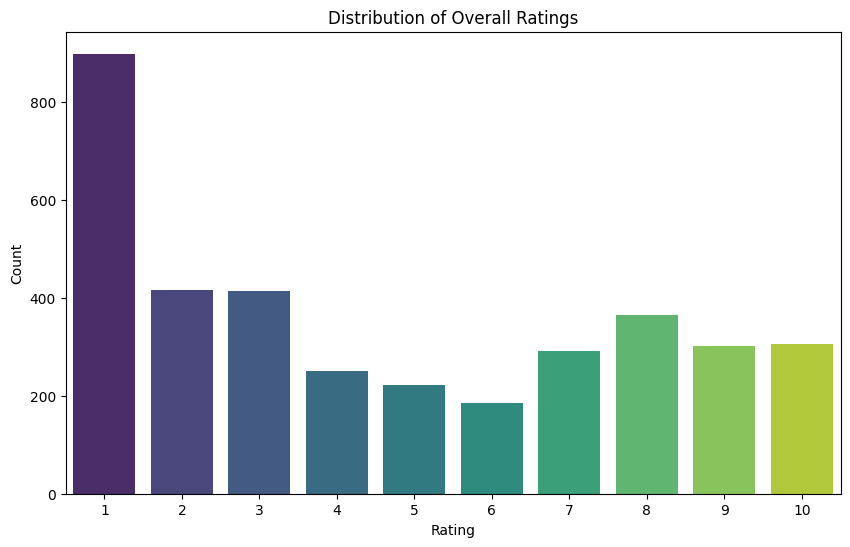

In [ ]:
# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

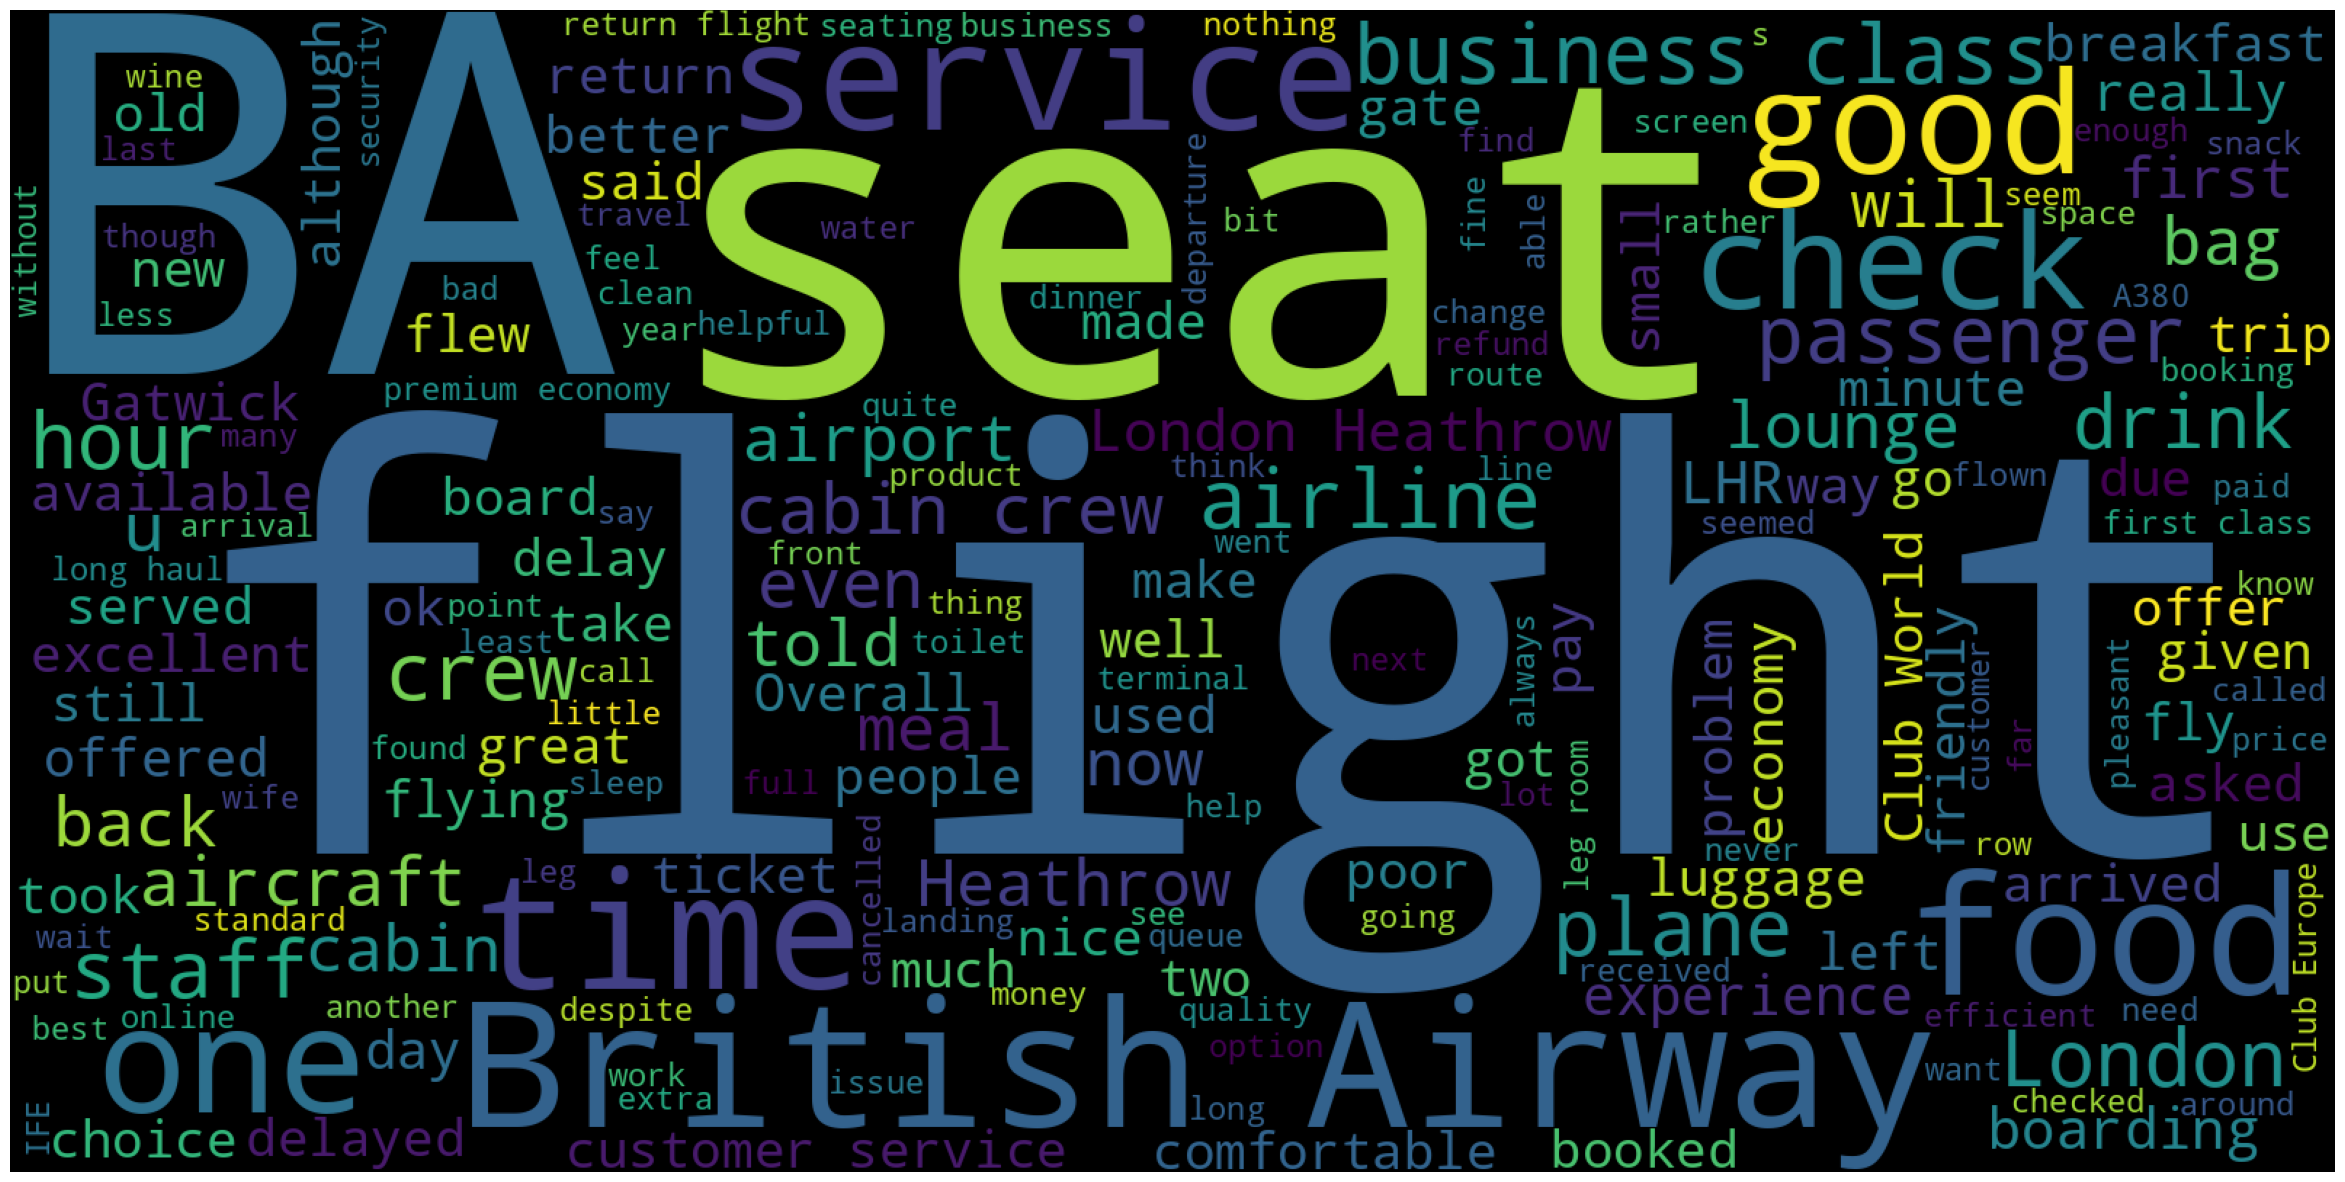

In [ ]:
# Visuallizing an overall Word Cloud from the given data

from wordcloud import WordCloud

wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(df['content']))

plt.figure(1,figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
# Clean the text data
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.strip()  # Remove leading/trailing whitespace
    return text


In [ ]:
# Clean the 'header' and 'content' columns
df['cleaned_header'] = df['header'].apply(clean_text)
df['cleaned_content'] = df['content'].apply(clean_text)

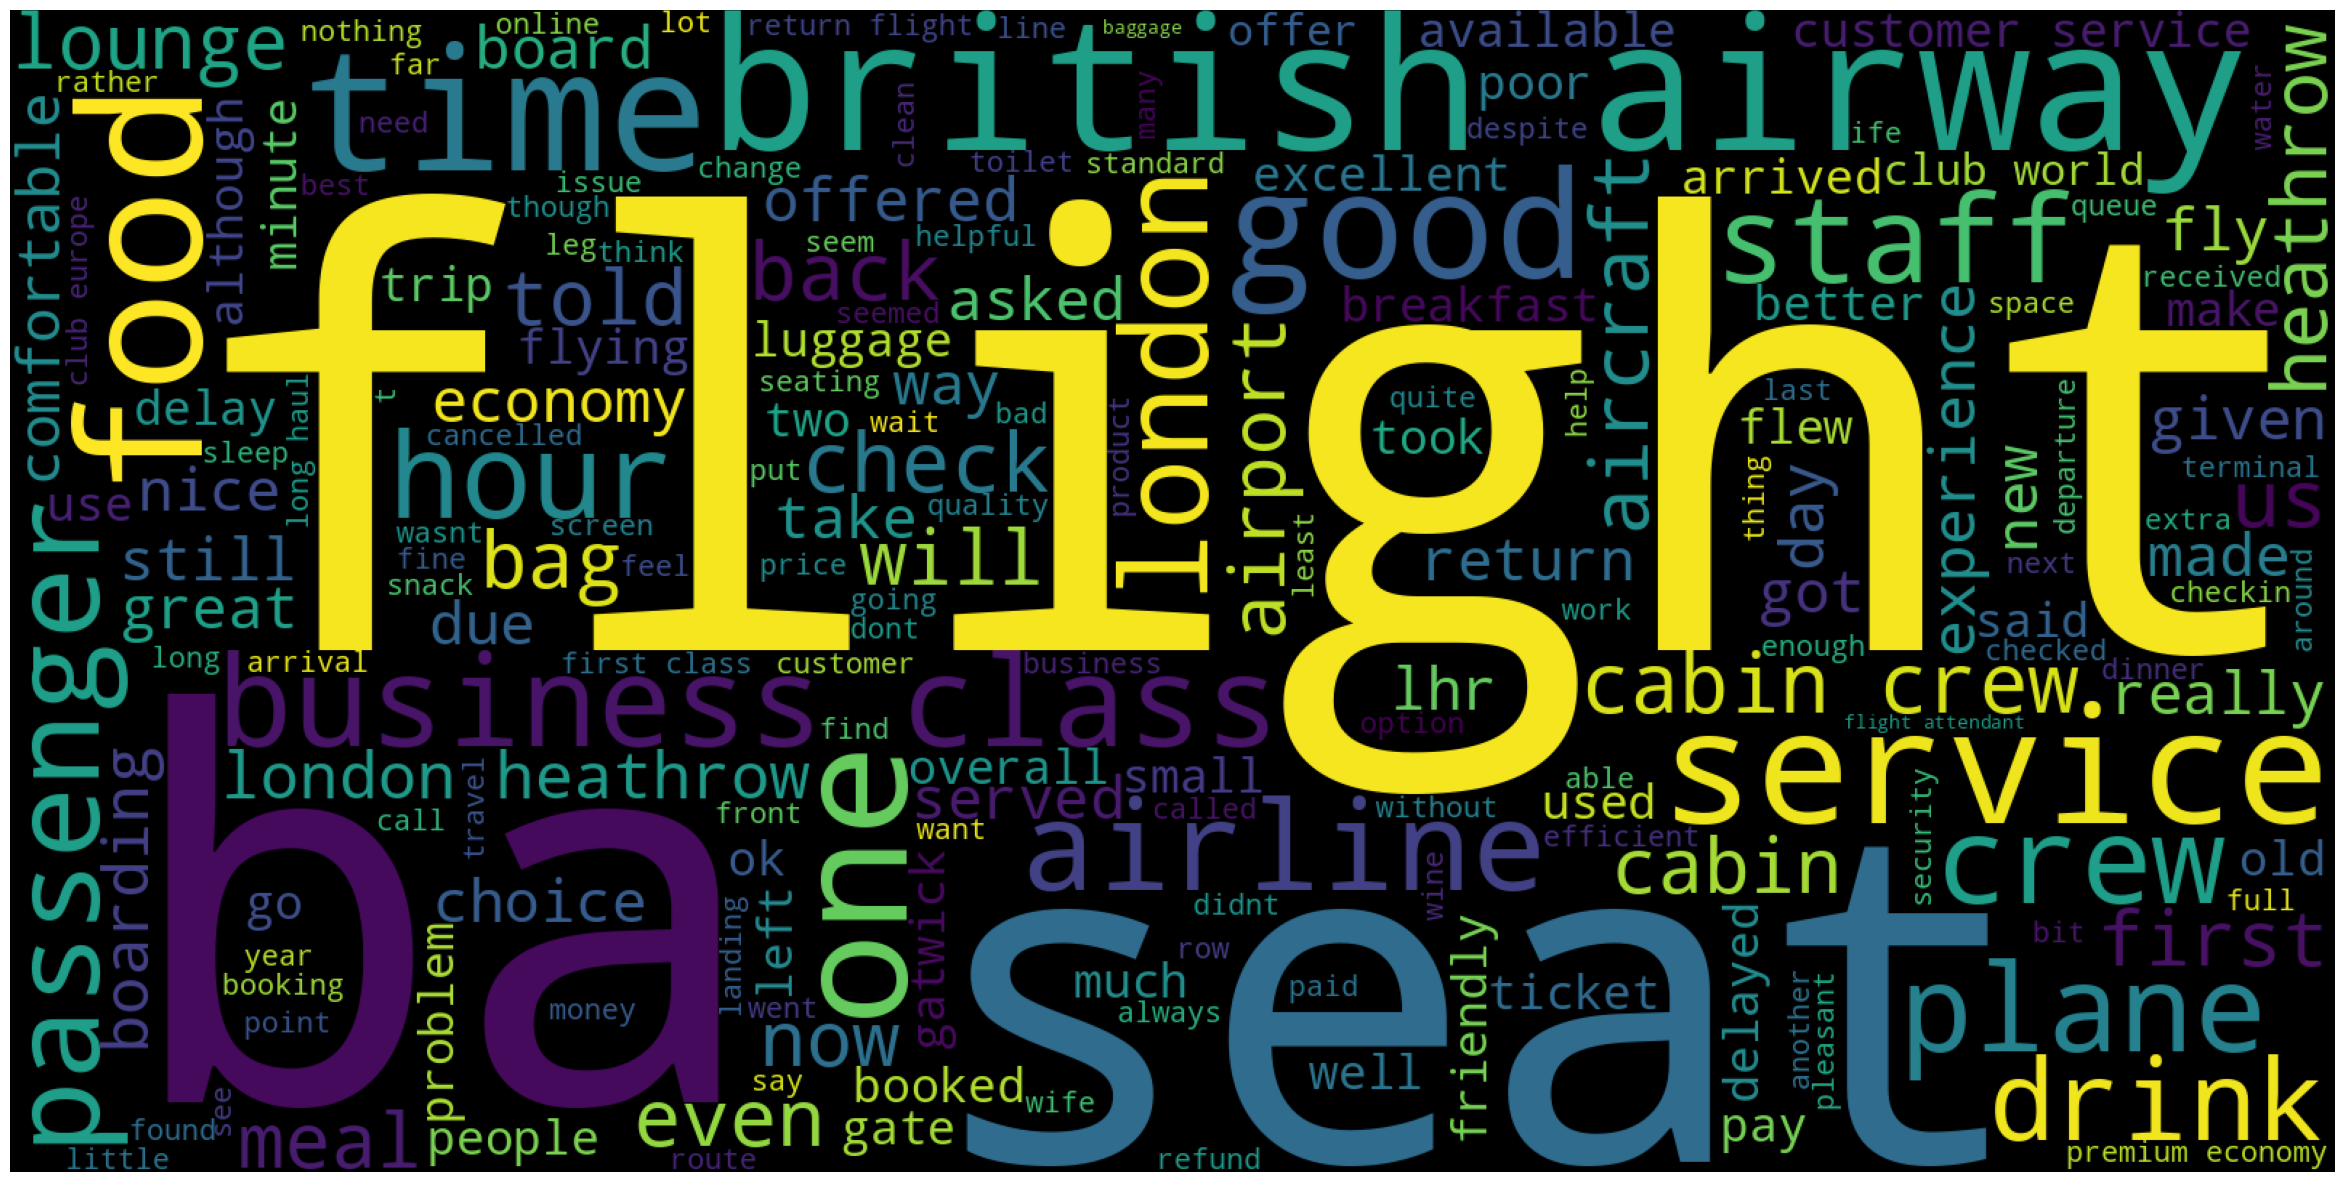

In [ ]:
# Visuallizing an overall Word Cloud from the given data

from wordcloud import WordCloud

wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(df['cleaned_content']))

plt.figure(1,figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
# Tokenize the cleaned text
nltk.download('punkt')
df['tokenized_header'] = df['cleaned_header'].apply(nltk.word_tokenize)
# Tokenize the cleaned text
df['tokenized_content'] = df['cleaned_content'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Remove stop words from tokenized header and content columns
df['tokenized_header'] = df['tokenized_header'].apply(lambda x: [word for word in x if word not in stop_words])
df['tokenized_content'] = df['tokenized_content'].apply(lambda x: [word for word in x if word not in stop_words])


In [ ]:
df.head()

,rating,header,author,date,place,content,aircraft,traveller_type,seat_type,route,...,cabin_staff_service,food_beverages,ground_service,value_for_money,recommended,entertainment,cleaned_header,cleaned_content,tokenized_header,tokenized_content
0,8,easy and enjoyable flight,38 reviews,2024-08-07,Lebanon,An excellent flight on BA CityFlyer. The plan...,Embraer 190,Couple Leisure,Economy Class,Dublin to London City,...,4.0,3.000000,4.0,4,yes,2.64236,easy and enjoyable flight,an excellent flight on ba cityflyer the plane ...,"[easy, enjoyable, flight]","[excellent, flight, ba, cityflyer, plane, clea..."
1,10,Crew were amazing and attentive,Janeks Volkovs,2024-08-07,United Kingdom,"Crew were amazing and attentive, nothing wa...",A320,Solo Leisure,Business Class,Riga to London,...,5.0,5.000000,4.0,5,yes,2.64236,crew were amazing and attentive,crew were amazing and attentive nothing was mi...,"[crew, amazing, attentive]","[crew, amazing, attentive, nothing, missed, de..."
2,1,missed my connecting flight,Mary Siniscalchi,2024-08-05,United States,I flew internationally for the first time in...,A320,Solo Leisure,Economy Class,Rome to Philadelphia via London,...,3.0,2.688738,1.0,1,no,2.64236,missed my connecting flight,i flew internationally for the first time in m...,"[missed, connecting, flight]","[flew, internationally, first, time, life, del..."
3,1,“time to change leadership team”,R Foster,2024-08-03,Italy,"BA, after subsequent delays and postponed dep...",A320,Business,Economy Class,London to Bologna,...,1.0,1.000000,1.0,1,no,2.64236,time to change leadership team,ba after subsequent delays and postponed depar...,"[time, change, leadership, team]","[ba, subsequent, delays, postponed, departure,..."
4,1,"avoid it at all cost!""",Kevin Butler,2024-08-02,Australia,It is embarrassing to have the word “Britis...,A380,Business,Business Class,Sydney to London,...,3.0,3.000000,1.0,1,no,2.00000,avoid it at all cost,it is embarrassing to have the word british at...,"[avoid, cost]","[embarrassing, word, british, attached, airlin..."


In [ ]:
# Display selected columns of the DataFrame
df1 = df[['header', 'content', 'cleaned_header', 'cleaned_content', 'tokenized_header', 'tokenized_content','rating']]

In [ ]:
# Define a function to categorize ratings
def categorize_rating(rating):
    if rating >= 7:
        return 'Positive'
    elif rating >= 4:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the function to the 'rating' column and create a new column 'rating_category'
df1['rating_category'] = df1['rating'].apply(categorize_rating)

# Define a function to categorize ratings and assign numerical values
def map_rating_to_number(rating):
    if rating >= 7:
        return 1  # Positive
    elif rating >= 4:
        return 0  # Neutral
    else:
        return -1  # Negative

# Apply the function to the 'rating' column and create a new column 'rating_value'
df1['rating_value'] = df1['rating'].apply(map_rating_to_number)

<ipython-input-27-ba6d670f52a2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['rating_category'] = df1['rating'].apply(categorize_rating)
<ipython-input-27-ba6d670f52a2>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['rating_value'] = df1['rating'].apply(map_rating_to_number)


In [ ]:
df1.head()

,header,content,cleaned_header,cleaned_content,tokenized_header,tokenized_content,rating,rating_category,rating_value
0,easy and enjoyable flight,An excellent flight on BA CityFlyer. The plan...,easy and enjoyable flight,an excellent flight on ba cityflyer the plane ...,"[easy, enjoyable, flight]","[excellent, flight, ba, cityflyer, plane, clea...",8,Positive,1
1,Crew were amazing and attentive,"Crew were amazing and attentive, nothing wa...",crew were amazing and attentive,crew were amazing and attentive nothing was mi...,"[crew, amazing, attentive]","[crew, amazing, attentive, nothing, missed, de...",10,Positive,1
2,missed my connecting flight,I flew internationally for the first time in...,missed my connecting flight,i flew internationally for the first time in m...,"[missed, connecting, flight]","[flew, internationally, first, time, life, del...",1,Negative,-1
3,“time to change leadership team”,"BA, after subsequent delays and postponed dep...",time to change leadership team,ba after subsequent delays and postponed depar...,"[time, change, leadership, team]","[ba, subsequent, delays, postponed, departure,...",1,Negative,-1
4,"avoid it at all cost!""",It is embarrassing to have the word “Britis...,avoid it at all cost,it is embarrassing to have the word british at...,"[avoid, cost]","[embarrassing, word, british, attached, airlin...",1,Negative,-1


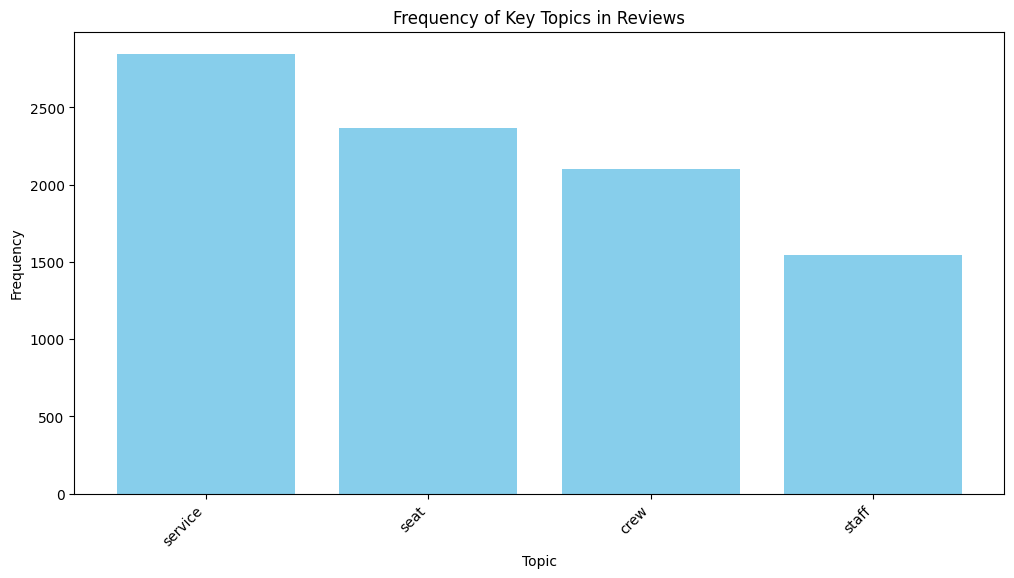

In [ ]:
# Define the key topics you want to track
key_topics = ["service", "seat", "crew", "staff"]

# Count occurrences of key topics
def count_key_topics(df1, key_topics):
    topic_counts = {topic: 0 for topic in key_topics}
    for tokens in df['tokenized_content']:
        for topic in key_topics:
            topic_counts[topic] += tokens.count(topic)
    return topic_counts

# Get the counts of the key topics
topic_counts = count_key_topics(df1, key_topics)

# Convert to DataFrame for plotting
topic_counts_df1 = pd.DataFrame(list(topic_counts.items()), columns=['Topic', 'Frequency'])

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(topic_counts_df1['Topic'], topic_counts_df1['Frequency'], color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Frequency of Key Topics in Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

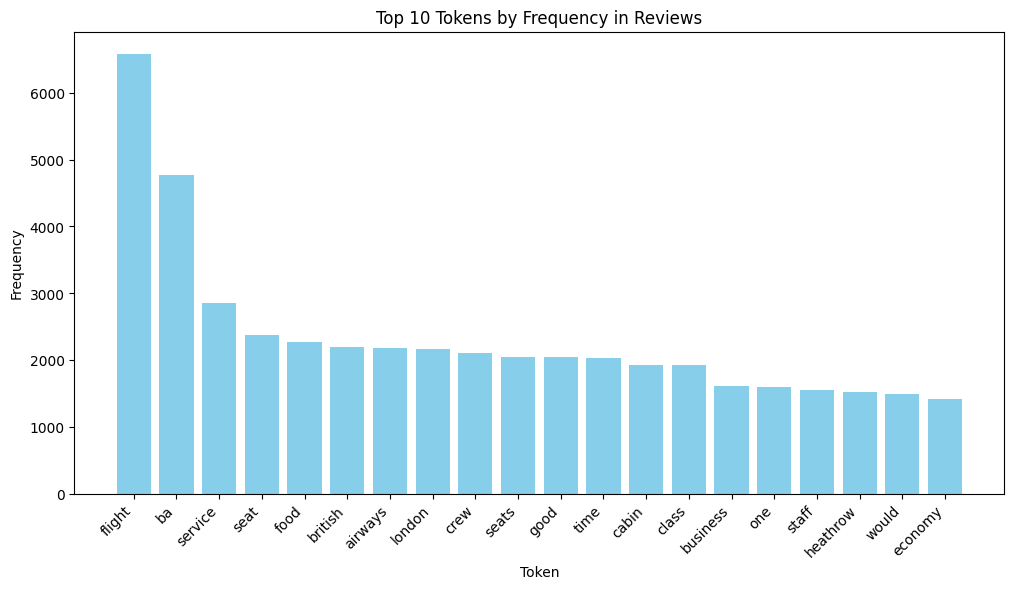

In [ ]:
# Flatten the list of tokenized content
all_tokens = [token for tokens in df1['tokenized_content'] for token in tokens]

# Count the frequency of each token
token_counts = Counter(all_tokens)

# Convert to DataFrame for plotting
token_counts_df1 = pd.DataFrame(token_counts.items(), columns=['Token', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Get the top 10 tokens
top_10_tokens_df1 = token_counts_df1.head(20)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_10_tokens_df1['Token'], top_10_tokens_df1['Frequency'], color='skyblue')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 10 Tokens by Frequency in Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

rating_category
Negative    1727
Positive    1264
Neutral      657
Name: count, dtype: int64
rating_category
Negative    47.341009
Positive    34.649123
Neutral     18.009868
Name: proportion, dtype: float64


<ipython-input-31-e8c82b350ea8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating_category', data=df1, palette=['green', 'red', 'gray'])


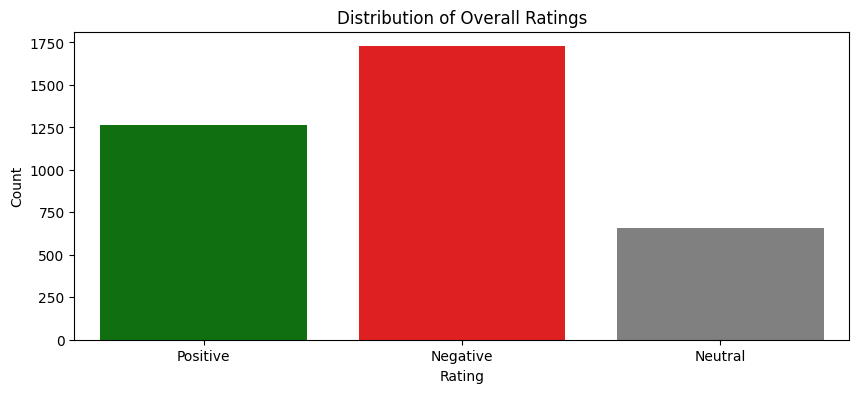

In [ ]:
print(df1['rating_category'].value_counts())
print(df1['rating_category'].value_counts(normalize=True) * 100)

# Distribution of Ratings
plt.figure(figsize=(10, 4))
sns.countplot(x='rating_category', data=df1, palette=['green', 'red', 'gray'])
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

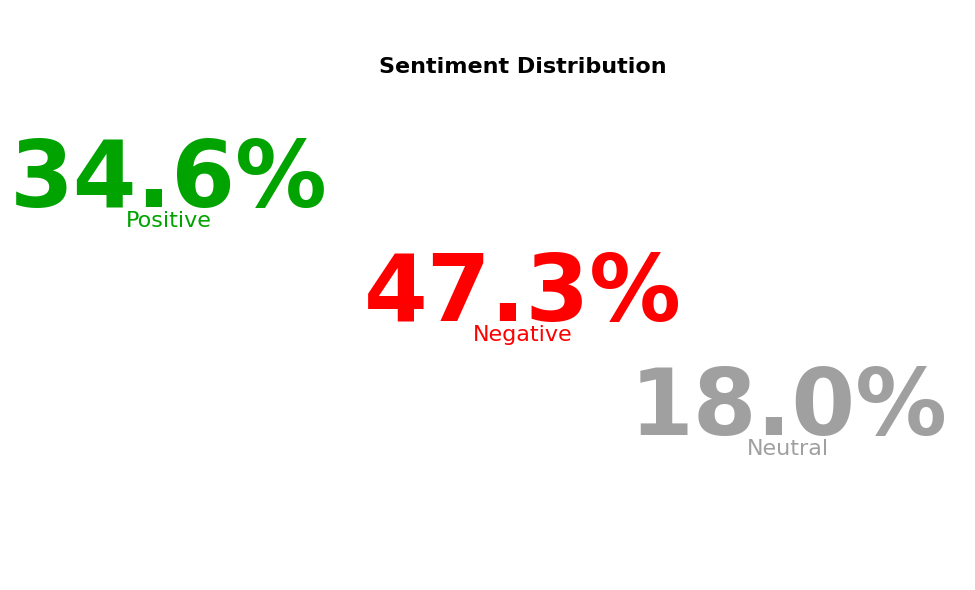

In [ ]:
# Step 1: Calculate percentages
percentage_data = df1['rating_category'].value_counts(normalize=True) * 100

# Step 2: Define sentiments, percentages, and colors
sentiments = percentage_data.index.tolist()
percentages = percentage_data.values.tolist()
colors = {
    'Positive': '#00A300',
    'Negative': '#FF0000',
    'Neutral': '#A0A0A0'
}
colors_list = [colors.get(sentiment, '#A0A0A0') for sentiment in sentiments]

# Step 3: Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Remove axis
ax.axis('off')

# Add title
ax.text(0.5, 0.9, 'Sentiment Distribution', fontsize=16, fontweight='bold', ha='center', va='center')

# Step 4: Define positions for sentiments
positions = {
    'Positive': (0.1, 0.7),
    'Negative': (0.5, 0.5),
    'Neutral': (0.8, 0.3)
}

# Step 5: Plot Sentiments
for sentiment, percentage, color in zip(sentiments, percentages, colors_list):
    x_pos, y_pos = positions.get(sentiment, (0.5, 0.5))
    ax.text(x_pos, y_pos, f"{percentage:.1f}%", fontsize=66, fontweight='bold', color=color, ha='center', va='center')
    ax.text(x_pos, y_pos - 0.07, sentiment, fontsize=16, color=color, ha='center', va='center')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
df.isnull().sum()

,0
rating,0
header,0
author,0
date,0
place,0
content,0
aircraft,0
traveller_type,0
seat_type,0
route,0
